In [1]:
# coding: utf-8

# In[1]:

from __future__ import division
import joblib
import glob
import os
import numpy as np
import nrrd
import numpy as np
from sklearn import datasets, svm, metrics, decomposition
from sklearn.externals import joblib
import time
from joblib import Parallel, delayed  
import multiprocessing
num_cores = multiprocessing.cpu_count()
USERPATH = os.path.expanduser("~")
print(USERPATH)
import six.moves.cPickle as pickle
# import tensorflow as tf

# import theano
# theano.config.device = 'gpu'
# theano.config.floatX = 'float32'


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# server = tf.train.Server.create_local_server()
# sess = tf.Session(server.target)

# from keras import backend as K
# K.set_session(sess)

# tb = TensorBoard(log_dir='/tmp/tensorboard', histogram_freq=1, write_graph=True)



# fix random seed for reproducibility
seed = 7
# checkpointer = ModelCheckpoint(filepath="weights2d.hdf5", verbose=1, save_best_only=True)
patchsize = [10,10,20]
spacing = [1,1,1]
notipsPath = USERPATH + "/preprocessed_data/notips_%d-%d-%d_%.2f-%.2f-%.2f/" %(tuple(patchsize)+tuple(spacing))
tipsPath = USERPATH + "/preprocessed_data/tips_%d-%d-%d_%.2f-%.2f-%.2f/" %(tuple(patchsize)+tuple(spacing))

def loadAllDataFromPath(path):
    # path in directorty
    
    cubeTipsPath = glob.glob(path + "/*/*.nrrd")
    # number of samples
    N = len(cubeTipsPath)
    
    cubeTips = []
    data = []
    for path_i in cubeTipsPath:
        cubeTips.append(nrrd.read(path_i))
    for i in range(N):
        # c = np.array(cubeTips[i][0])  # for patches of size 20,20,20
        c = np.array(cubeTips[i][0][:,:,:]) # for patches of size 10,10,10
        if c.shape==tuple(patchsize):
            data.append(np.array(c))
    output = np.array(data, dtype='float32')
    print('number of sample %d' %len(output))
    return output


print(tipsPath)
tips = loadAllDataFromPath(tipsPath)
notips = loadAllDataFromPath(notipsPath)[:5*len(tips)]

/home/ubuntu


Using Theano backend.
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '20986' (I am process '30151')
Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5103)
/home/ubuntu/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:601: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


/home/ubuntu/preprocessed_data/tips_10-10-20_1.00-1.00-1.00/
number of sample 616
number of sample 9800


In [2]:
print(len(tips), len(notips))

target_0 = [0 for i in range(len(notips))]
target_1 = [1 for i in range(len(tips))]
y_train = np.array(target_0 + target_1)
print('target shape:', y_train.shape)
X_train = np.array(list(notips)+list(tips))

print('data shape:', X_train.shape)

616 3080
target shape: (3696,)
data shape: (3696, 10, 10, 20)


In [3]:
o = 7
# f_Xtrain = open('X_data_n%d.save'%o, 'wb')
# f_ytrain = open('y_data_n%d.save'%o, 'wb')

# pickle.dump(X_train, f_Xtrain, protocol=pickle.HIGHEST_PROTOCOL)
# pickle.dump(y_train, f_ytrain, protocol=pickle.HIGHEST_PROTOCOL)

# f_Xtrain.close()
# f_ytrain.close()


# In[6]:

# Load the dataset
f_Xdata = open('X_data_n%d.save'%o, 'rb')
f_ydata = open('y_data_n%d.save'%o, 'rb')

X_data = pickle.load(f_Xdata)
X_data = X_data.astype('float32')

# normalize the raw data
X_data -= np.mean(X_data)
X_data /= np.std(X_data)

## second method for normalization
# X_data /= 255

y_data= pickle.load(f_ydata)
y_data_binary = to_categorical(y_data)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_data)
y_data = encoder.transform(y_data)

print("Data shape and label shape")
print(X_data.shape, y_data.shape)

Data shape and label shape
(3696, 10, 10, 20) (3696,)


In [28]:
# In[7]:

def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


# init the global var
model = 0
m = 16

In [37]:
def create_baseline():

    nb_classes = 1

    # create model
    global model
    if m ==7:
        model = Sequential()

        model.add(Convolution2D(10, 10, 2, border_mode='same',
                                input_shape=(10,10,10)))
        model.add(Activation('relu'))
        model.add(Convolution2D(10, 3, 3))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))

        model.add(Convolution2D(40, 5, 3, border_mode='same' ))
        model.add(Activation('relu'))
        model.add(Convolution2D(40, 5, 3, border_mode='same'))
        model.add(Activation('relu'))
        model.add(Convolution2D(40, 5, 3))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))

        model.add(Flatten())
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes))
        model.add(Activation('sigmoid'))

    if m == 11:
        model = Sequential()
        model.add(Convolution2D(10, 10, 10, border_mode='same',
                                batch_input_shape=(10, 10, 10)))
        # model.add(ZeroPadding2D((1, 1), batch_input_shape=(1, 3, 10, 10)))
        model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(Flatten(input_shape=(512,3,3)))
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes))
        model.add(Activation('sigmoid'))

    if m ==13:
        model = Sequential()
        model.add(ZeroPadding2D((1, 1), input_shape=(10,10,10)))
        model.add(Convolution2D(10, 10, 2, border_mode='same',
                                ))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(Dropout(0.5))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
        model.add(MaxPooling2D((2, 2), strides=(1, 1)))

        model.add(Dropout(0.5))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
        model.add(MaxPooling2D((2, 2), strides=(1, 1)))

        model.add(Dropout(0.5))
        #
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
        model.add(MaxPooling2D((2, 2), strides=(1, 1)))

        model.add(Dropout(0.5))
        #
        # model.add(ZeroPadding2D((1, 1)))
        # model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
        # model.add(ZeroPadding2D((1, 1)))
        # model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
        # model.add(ZeroPadding2D((1, 1)))
        # model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
        # model.add(MaxPooling2D((2, 2), strides=(1, 1)))

        # model.add(Convolution2D(40, 3, 3, border_mode='same' ))
        # model.add(Activation('relu'))
        # model.add(Convolution2D(40, 3, 3, border_mode='same'))
        # model.add(Activation('relu'))
        # model.add(Convolution2D(40, 3, 3))
        # model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(Dropout(0.1))

        model.add(Flatten())
        model.add(Dense(512*3*3))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes))
        model.add(Activation('sigmoid'))
        
    if m ==14:
        model = Sequential()

        model.add(Convolution2D(20,9,9, border_mode='same',
                                input_shape=(10,10,10)))
#         model.add(Activation('relu'))
        model.add(Convolution2D(20,9,9))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))

#         model.add(Convolution2D(40, 5, 3, border_mode='same' ))
#         model.add(Activation('relu'))
#         model.add(Convolution2D(40, 5, 3, border_mode='same'))
#         model.add(Activation('relu'))
#         model.add(Convolution2D(40, 5, 3))
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.1))

        model.add(Flatten())
#         model.add(Dense(480))
#         model.add(Activation('relu'))
#         model.add(Dropout(0.5))
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes))
        model.add(Activation('sigmoid'))
        
        
    if m ==15:
        model = Sequential()

        model.add(Convolution2D(20,9,9, border_mode='same',
                                input_shape=(10,10,20)))
        model.add(Activation('relu'))
        model.add(Convolution2D(20,9,9))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))

        model.add(Flatten())

        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes))
        model.add(Activation('sigmoid'))
    
    if m == 16:
        model = Sequential()

        model.add(Convolution3D(20,9,9,18, border_mode='same',
                                input_shape=(1,10,10,20)))
        model.add(Activation('relu'))
        model.add(Convolution3D(20,9,9,19))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes))
        model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

# np.random.seed(seed)
estimators = []
# estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=100,
                                          batch_size=64, verbose=1)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(y=y_data, n_folds=2, shuffle=True)#, random_state=seed)
results = cross_val_score(pipeline, np.expand_dims(X_data, 1), y_data, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

json_string = model.to_json()
model.save_weights('my_model_weights_2d_%d.h5'%m, overwrite=True)
open('my_model_architecture%d.json'%m, 'w').write(json_string)

Epoch 1/100
1848/1848 [==============================] - 9s - loss: 0.5059 - acc: 0.8155     
Epoch 2/100
1848/1848 [==============================] - 9s - loss: 0.4088 - acc: 0.8328     
Epoch 3/100
1848/1848 [==============================] - 9s - loss: 0.3448 - acc: 0.8333     
Epoch 4/100
1848/1848 [==============================] - 9s - loss: 0.3545 - acc: 0.8333     
Epoch 5/100
1848/1848 [==============================] - 9s - loss: 0.3389 - acc: 0.8333     
Epoch 6/100
1848/1848 [==============================] - 9s - loss: 0.3239 - acc: 0.8333     
Epoch 7/100
1848/1848 [==============================] - 9s - loss: 0.2973 - acc: 0.8333     
Epoch 8/100
1848/1848 [==============================] - 9s - loss: 0.2974 - acc: 0.8333     
Epoch 9/100
1848/1848 [==============================] - 9s - loss: 0.2838 - acc: 0.8333     
Epoch 10/100
1848/1848 [==============================] - 9s - loss: 0.3112 - acc: 0.8333     
Epoch 11/100
1848/1848 [==============================] - 9

2637

In [36]:
np.expand_dims(X_data, 1).shape

(3696, 1, 10, 10, 20)

In [38]:
# we load a test case and the model

# model = model_from_json(open('my_model_architecture%d.json'%m).read())
# model.load_weights('my_model_weights_2d_%d.h5'%m)
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
print(spacing)
nrrdData = nrrd.read(USERPATH + '/preprocessed_data/LabelMaps_%.2f-%.2f-%.2f/064/case.nrrd'%(tuple(spacing)))
im = nrrdData[0]
im = im[100:160,80:130,70:130]
s = im.shape
print(s)
p=10
print(patchsize)

<ufunc 'spacing'>


TypeError: 'numpy.ufunc' object is not iterable

In [68]:
import pyprind
import sys
def findtips(N):
    '''
    Find the tip in the image by computing testing patches at every voxel position
    TODO: make this method more efficient
    '''
    p0, p1, p2 = patchsize
    xmiddle = s[0]//2
    ymiddle = s[1]//2
    zmiddle = s[2]//2
    
    x0= xmiddle - xmiddle//N
    y0= ymiddle - ymiddle//N
    z0= zmiddle - zmiddle//N
    
    xe= xmiddle + xmiddle//N
    ye= ymiddle + ymiddle//N
    ze= zmiddle + zmiddle//N
    
    tips = []
    bar = pyprind.ProgBar(xmiddle//N*2, title='Find_tip', stream=sys.stdout)
    for xi in range(x0, xe-p0):
        for yi in range(y0, ye-p1):
            vols = [im[xi:xi+p0,yi:yi+p1,zi:zi+p2] for zi in range(z0,ze-p2)]
            # we normalize the data (centered on mean 0 and rescaled in function of the STD)
            volnorm = [ x-np.mean(x) for x in vols]
            volnorm2 = [x/np.std(x) for x in volnorm]
            cube = np.array(volnorm2)
            res = model.predict_proba(np.expand_dims(cube,1), batch_size=32, verbose=False)
            indices = np.where(res[:,0]>0.8)
            # we add the coordinates of the center voxel of the patches that tested positive
            for z in indices[0]:
                tips.append([xi+p0/2,yi+p1/2,z0+p2/2+z])
        bar.update()
    return tips

In [69]:
# find the tips for patches with size p
res=findtips(1)

Find_tip
0%                          100%
[########################      ] | ETA: 00:00:19

In [70]:
print(res)

[[5.0, 5.0, 14.0], [5.0, 5.0, 15.0], [5.0, 5.0, 16.0], [5.0, 5.0, 17.0], [5.0, 5.0, 18.0], [5.0, 5.0, 19.0], [5.0, 5.0, 20.0], [5.0, 5.0, 42.0], [5.0, 5.0, 43.0], [5.0, 5.0, 44.0], [5.0, 5.0, 45.0], [5.0, 5.0, 46.0], [5.0, 5.0, 47.0], [5.0, 6.0, 10.0], [5.0, 6.0, 11.0], [5.0, 6.0, 12.0], [5.0, 6.0, 13.0], [5.0, 6.0, 14.0], [5.0, 6.0, 15.0], [5.0, 6.0, 16.0], [5.0, 6.0, 17.0], [5.0, 6.0, 18.0], [5.0, 6.0, 19.0], [5.0, 6.0, 20.0], [5.0, 6.0, 21.0], [5.0, 6.0, 22.0], [5.0, 6.0, 41.0], [5.0, 6.0, 42.0], [5.0, 6.0, 43.0], [5.0, 6.0, 44.0], [5.0, 6.0, 45.0], [5.0, 6.0, 46.0], [5.0, 6.0, 47.0], [5.0, 7.0, 12.0], [5.0, 7.0, 13.0], [5.0, 7.0, 14.0], [5.0, 7.0, 15.0], [5.0, 7.0, 16.0], [5.0, 7.0, 17.0], [5.0, 7.0, 18.0], [5.0, 7.0, 19.0], [5.0, 7.0, 39.0], [5.0, 7.0, 40.0], [5.0, 7.0, 41.0], [5.0, 7.0, 42.0], [5.0, 7.0, 43.0], [5.0, 7.0, 44.0], [5.0, 7.0, 45.0], [5.0, 7.0, 46.0], [5.0, 8.0, 38.0], [5.0, 8.0, 39.0], [5.0, 8.0, 40.0], [5.0, 8.0, 41.0], [5.0, 8.0, 42.0], [5.0, 8.0, 43.0], [5.0, 8.0

## Creation of a labelmap from the voxel that tested positive

In [71]:
mask = np.zeros(im.shape)
for coord in res:
    mask[int(coord[0]),int(coord[1]),int(coord[2])]=1.0
nrrd.write('mask%d.nrrd'%m, mask)
nrrd.write('im%d.nrrd'%m, im)

Populating the interactive namespace from numpy and matplotlib


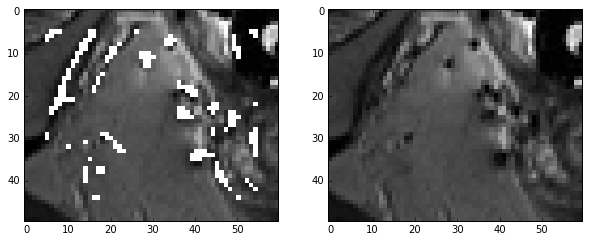

In [72]:
%matplotlib inline
%pylab inline
# We display one axial slice
Z = 13
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax1.imshow((np.clip(mask[:,:,Z]*255+im[:,:,Z]/2,a_min=0,a_max=200)).transpose(),  cmap='gray', interpolation='nearest')
ax2 = fig.add_subplot(122)
ax2.imshow(im[:,:,Z].transpose(), cmap='gray', interpolation='nearest')